In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import utils
import pickle
from scipy.optimize import minimize

In [2]:
# data_list = [T4_arclight, T4_gcamp]
# speed = [15, 30, 60, 120]
# peak_tuning = np.empty((len(data_list),len(speed),12)) #first dimesnion is for Arclight, Gcamp, Model respectively. 
#                                 #second dimension is for 4 speeds, 3rd dimension is for 12 directions
# for j in range(len(data_list)):
#     for i in range(4):
#         peak_tuning[j,i,:] = data_list[j][:,i:48+i:4].max(axis=0)

In [150]:
def calc_peaktuning(data_list, speed, contrast =False):
    peak_tuning = np.empty((len(data_list),len(speed),12)) #first dimesnion is for Arclight, Gcamp, Model respectively. 
                                #second dimension is for 4 speeds, 3rd dimension is for 12 directions
    for j in range(len(data_list)):
        for i in range(4):
            peak_tuning[j,i,:] = data_list[j][:,i:48+i:4].max(axis=0)
    peak_tuning[0] = peak_tuning[0] / peak_tuning[0].max()
    peak_tuning[1] = peak_tuning[1] / peak_tuning[1].max()
    if contrast == True:
        peak_tuning = peak_tuning[:,::-1,:]
        
    return peak_tuning

def plot_oripeaktuning(data_list, speed, color, ylim1=(0,0.08),ylim2=(0,2.5), fig_size=(15,10), title='',savefig=False, contrast = False):
    peak_tuning = calc_peaktuning(data_list, speed, contrast)

            
    def polar_plot(data, rotations_rad, ax, ylim,marker='o', color='r',label=''):
        data = np.append(data, data[0])
        ax.plot(rotations_rad, data, marker=marker, markersize=3.0,color=color,label=label,linewidth=2.0)
        #ax.set_facecolor('#d3d3d3')
        ax.set_facecolor((0.9,0.9,0.9,0.7))
        #ax.plot(rotations_rad, data, color=color, label=label,linewidth=2.0)
        ax.set_ylim(ylim)
        
    rotations = np.arange(0.0,390.0,30.0)
    rotations_rad = (rotations * np.pi) / 180
    fig, ax = plt.subplots(1,4,subplot_kw={'projection': 'polar'}, figsize=fig_size)
    for i in range(4):
        polar_plot(peak_tuning[0,i,:], rotations_rad, ax[i], ylim=ylim1,color='k',label='Arclight' );
        polar_plot(peak_tuning[1,i,:], rotations_rad, ax[i], ylim=ylim2,color='r',label='GCaMP' );
          
        
#     for j in range(2):
#         for i in range(4):
#             if j == 1:
#                 polar_plot(peak_tuning[1,i,:], rotations_rad, ax[1][i], ylim=ylim2,color='r',label='GCaMP' );
#                 #polar_plot(peak_tuning[2,i,:], rotations_rad, ax[1][i], ylim=(0,225),color='r' );
#             if j == 0:
#                 polar_plot(peak_tuning[0,i,:], rotations_rad, ax[0][i], ylim=ylim1,color='k',label='Arclight' );
    ax[3].legend(loc=1, bbox_to_anchor=(0,0,1,1.15),frameon=False);
    #ax[3].legend(loc=1, bbox_to_anchor=(0,0,1,1.1),frameon=False);
                
    row = ['Arclight','GCaMP']
    
    for axis,s in zip(ax,speed):
        if contrast == True:
            axis.set_title(str(s)+'%',fontsize=12, pad=20);
        else:
            axis.set_title(str(s)+' deg/s',fontsize=12, pad=20);
        
    plt.subplots_adjust()
    plt.tight_layout();
    #ax[1][0].arrow(0,0,angle_rad, mag*200)
    if savefig:
        plt.savefig('figures/'+title+'.pdf',dpi=1000);
    
def calc_Ldir(peak_tuning):
    Ldir_array = np.empty((peak_tuning.shape[0],peak_tuning.shape[1],2)) #first dimesnion is for Arclight, Gcamp, Model respectively. 
                                #second dimension is for 4 speeds, 3rd dimension is for angle and magnitude
    def Ldir(data):
        rot = np.arange(0.0,360.0,30.0)
        rot_rad = (rot*np.pi)/180
        data_x = np.sum(data*np.cos(rot_rad))
        data_y = np.sum(data*np.sin(rot_rad))
        angle_rad = np.arctan(data_y/data_x)
        if angle_rad <0.0:
            angle_rad = angle_rad+np.pi
        mag = np.sqrt(data_y**2 + data_x**2) / np.sum(data)
        return (angle_rad, mag)
    
    for j in range(peak_tuning.shape[0]):
        for i in range(peak_tuning.shape[1]):
            Ldir_array[j,i,:] = Ldir(peak_tuning[j,i,:])
    Ldir_array = np.nan_to_num(Ldir_array)
    
    return Ldir_array

def plot_Ldir_mag(peak_tuning,speed=[15,30,60,120],title='',savefig=False,contrast=False):
    Ldir = calc_Ldir(peak_tuning)
    Ldir_mag = Ldir[:,:,1]
    f, ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(4,4))
    #ax.plot(Ldir_mag[1]);
    n = len(speed)
    ax.plot(Ldir_mag[0],marker='o',color='k',label='Arclight');
    ax.plot(Ldir_mag[1],marker='o',color='red',label='GCaMP');
    ax.legend(loc=0,frameon=False);
    ax.set_title('Ldir')
    ax.set_ylim(0.0,1.0);
    if contrast == True:
        ax.set_xlabel('Contrast(%)',fontsize=12)
    else :
        ax.set_xlabel('Speed(deg/s)',fontsize=12)
    plt.xticks(range(0,n),speed); 
    if savefig:
        plt.savefig('figures/'+title+'.pdf',dpi=1000);
        
def plot_Ldir(peak_tuning,fig_size=(15,4), title='',savefig=False):
    Ldir_array = np.empty((peak_tuning.shape[0],peak_tuning.shape[1],2)) #first dimesnion is for Arclight, Gcamp, Model respectively. 
                                #second dimension is for 4 speeds, 3rd dimension is for angle and magnitude
    def Ldir(data):
        rot = np.arange(0.0,360.0,30.0)
        rot_rad = (rot*np.pi)/180
        data_x = np.sum(data*np.cos(rot_rad))
        data_y = np.sum(data*np.sin(rot_rad))
        angle_rad = np.arctan(data_y/data_x)
        if angle_rad <0.0:
            angle_rad = angle_rad+np.pi
        mag = np.sqrt(data_y**2 + data_x**2) / np.sum(data)
        return (angle_rad, mag)
    
    for j in range(peak_tuning.shape[0]):
        for i in range(peak_tuning.shape[1]):
            Ldir_array[j,i,:] = Ldir(peak_tuning[j,i,:])
    Ldir_array = np.nan_to_num(Ldir_array)
    
    fig, ax = plt.subplots(1,4,subplot_kw={'projection': 'polar'}, figsize=fig_size)
    for i in range(4):
        ax[i].annotate("", xytext=(0.0,0.0), xy=(Ldir_array[0,i,0],Ldir_array[0,i,1]),arrowprops=dict(facecolor='black'))
        ax[i].annotate("", xytext=(0.0,0.0), xy=(Ldir_array[1,i,0],Ldir_array[1,i,1]),
                       arrowprops=dict(facecolor='blue'))
        #ax[i].annotate("", xytext=(0.0,0.0), xy=(Ldir_array[2,i,0],Ldir_array[2,i,1]),arrowprops=dict(facecolor='red'))
    ax[0].set_ylabel('Ldir', rotation=0,fontsize=12, labelpad=60);
    plt.tight_layout();    
    if savefig:
        plt.savefig('figures/'+title+'.pdf',dpi=1000);

In [151]:
filename = 'data/forAbhi/Velocity_Data.mat'
data = scipy.io.loadmat(filename)
T4_arclight = data['data']
T4_gcamp = data['data2']

In [152]:
T4_arclight.shape, T4_gcamp.shape

((113, 48), (113, 48))

In [153]:
# filename = 'data/T4c_ArcLight/ARCOri_Velocity_Mean.mat'
# T4_arclight = scipy.io.loadmat(filename)['PDmean']

# filename = 'data/T4c_GCaMP/Ori_Mean_Velocity.mat'
# T4_gcamp = scipy.io.loadmat(filename)['PDmean']

# T4_arclight.shape, T4_gcamp.shape

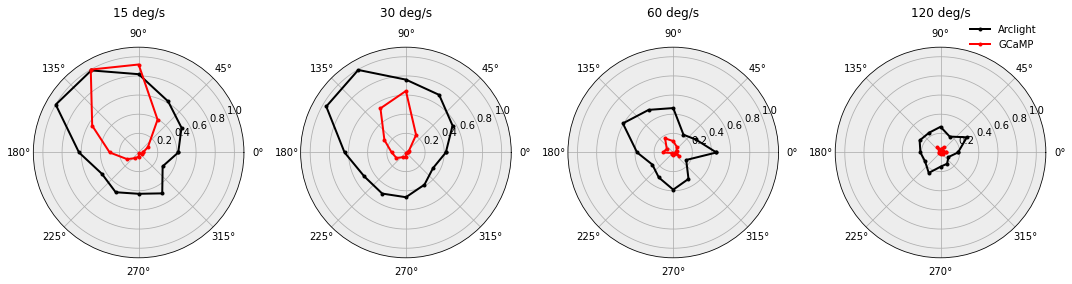

In [154]:
data_list = [T4_arclight, T4_gcamp]
velocity = [15, 30, 60, 120]
peak_tuning = calc_peaktuning(data_list, speed=velocity)
plot_oripeaktuning(data_list,speed=velocity, fig_size=(15,4), ylim1=(0.0,1.1),ylim2=(0.0,1.1),color=['k','r'],title='Speed_Ori_Tuning',savefig=True);

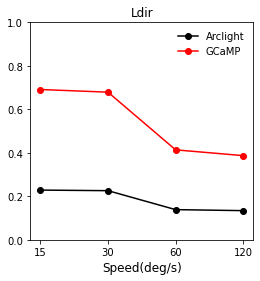

In [155]:
plot_Ldir_mag(peak_tuning, title='Ldir_Speed_Ori_Tuning',savefig=True);

In [156]:
filename = 'data/forAbhi/Contrast_Data.mat'
data = scipy.io.loadmat(filename)
T4_arclight = data['data']
T4_gcamp = data['data2']

In [157]:
# filename = 'data/T4c_ArcLight/ARCOri_Contrast_Mean.mat'
# T4_arclight = scipy.io.loadmat(filename)['PDmean']
# #T4_arclight = T4_arclight[:,::-1]

# filename = 'data/T4c_GCaMP/Ori_Mean_Contrast.mat'
# T4_gcamp = scipy.io.loadmat(filename)['PDmean']
# #T4_gcamp = T4_gcamp[:,::-1]

T4_arclight.shape, T4_gcamp.shape

((113, 48), (113, 48))

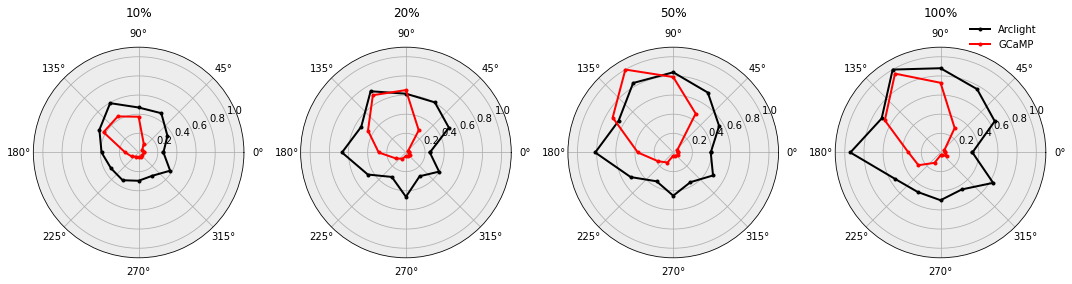

In [158]:
data_list = [T4_arclight, T4_gcamp]
contrast = [10, 20, 50, 100]
peak_tuning = calc_peaktuning(data_list, speed=velocity, contrast = True)
plot_oripeaktuning(data_list,speed=contrast, fig_size=(15,4), ylim1=(0.0,1.1),ylim2=(0.0,1.1),color=['k','r'],title='Contrast_Ori_Tuning',savefig=True, contrast=True);

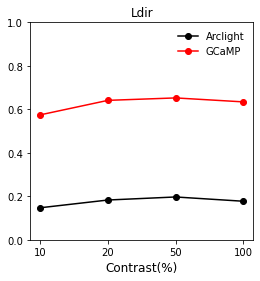

In [159]:
plot_Ldir_mag(peak_tuning,speed=contrast, title='Ldir_Contrast_Ori_Tuning',savefig=True,contrast=True);